## 1. Dependencies

In [1]:
import joblib
import importlib
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import os
import pandas as pd
import sys
import tempfile

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# add the src directory to the path to import custom modules
sys.path.append('../src')

import clustering
importlib.reload(clustering)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
from clustering import plot_pca_clusters

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

## 2. Load Full Dataset

In [4]:
data_processed_folder = '../data/processed'
os.makedirs(data_processed_folder, exist_ok=True)

In [5]:
filename = 'hyrox_full_data.csv'
file_path = os.path.join(data_processed_folder, filename)
df = pd.read_csv(file_path)
print(f"Data shape: {df.shape}")

Data shape: (167743, 32)


In [6]:
df.head(1)

,id,event_name,gender,age_min,age_max,total_time,work_time,roxzone_time,run_time,run_1,1000m Ski,roxzone_1,run_2,50m Sled Push,roxzone_2,run_3,50m Sled Pull,roxzone_3,run_4,80m Burpee Broad Jump,roxzone_4,run_5,1000m Row,roxzone_5,run_6,200m Farmer Carry,roxzone_6,run_7,100m Sandbag Lunges,roxzone_7,run_8,100 Wall Balls
0,"111008_Diensthuber, Josef_GER",S6 2023 München,0,40.0,44.0,59.116667,25.516667,3.433333,30.166667,3.2,4.1,0.033333,3.6,2.116667,0.45,3.933333,3.333333,0.583333,3.85,3.3,0.65,3.8,4.216667,0.466667,3.833333,1.25,0.666667,3.783333,3.083333,0.583333,4.166667,4.116667


## 3. Time Normalize Across Stations using Z-score

Z-score normalization is needed to make performance across stations directly comparable, given that each station has a different time scale, e.g., Wall Balls may take 6 minutes while a Farmer Carry might only take 2. 

This allows us to understand how much faster or slower a participant was **relative to others**, regardless of the absolute time. It helps reveal strengths and weaknesses  comparing how far one user is from the average (residual analysis).

> **Results:**
>
> z = 0: The time is right in the middle.
> z = 2: The time was much slower than average.
> z = -1: The time was faster than average.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167743 entries, 0 to 167742
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     167743 non-null  object 
 1   event_name             167743 non-null  object 
 2   gender                 167743 non-null  int64  
 3   age_min                167638 non-null  float64
 4   age_max                167638 non-null  float64
 5   total_time             167743 non-null  float64
 6   work_time              167743 non-null  float64
 7   roxzone_time           167743 non-null  float64
 8   run_time               167743 non-null  float64
 9   run_1                  167743 non-null  float64
 10  1000m Ski              167743 non-null  float64
 11  roxzone_1              167743 non-null  float64
 12  run_2                  167743 non-null  float64
 13  50m Sled Push          167743 non-null  float64
 14  roxzone_2              167743 non-nu

In [8]:
# define stations columns
stations = df.columns[9:32].tolist()
stations_agg = df.columns[5:9].tolist()
stations_context = df.columns[2:5].tolist() + stations
print(f"Stations: {stations}")
print(f"Stations Agg: {stations_agg}")
print(f"Stations + Context (gender, age): {stations_context}")

Stations: ['run_1', '1000m Ski', 'roxzone_1', 'run_2', '50m Sled Push', 'roxzone_2', 'run_3', '50m Sled Pull', 'roxzone_3', 'run_4', '80m Burpee Broad Jump', 'roxzone_4', 'run_5', '1000m Row', 'roxzone_5', 'run_6', '200m Farmer Carry', 'roxzone_6', 'run_7', '100m Sandbag Lunges', 'roxzone_7', 'run_8', '100 Wall Balls']
Stations Agg: ['total_time', 'work_time', 'roxzone_time', 'run_time']
Stations + Context (gender, age): ['gender', 'age_min', 'age_max', 'run_1', '1000m Ski', 'roxzone_1', 'run_2', '50m Sled Push', 'roxzone_2', 'run_3', '50m Sled Pull', 'roxzone_3', 'run_4', '80m Burpee Broad Jump', 'roxzone_4', 'run_5', '1000m Row', 'roxzone_5', 'run_6', '200m Farmer Carry', 'roxzone_6', 'run_7', '100m Sandbag Lunges', 'roxzone_7', 'run_8', '100 Wall Balls']


In [9]:
# Z-score normalization (standardization)
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()

df_zscore1 = pd.DataFrame(scaler1.fit_transform(df[stations]), columns=stations)
df_zscore2= pd.DataFrame(scaler2.fit_transform(df[stations_agg]), columns=stations_agg)
df_zscore3= pd.DataFrame(scaler3.fit_transform(df[stations_context]), columns=stations_context)

# add normalized profile back to df
for col in stations:
    df[f'{col}_zscore'] = df_zscore1[col]

for col in stations_agg:
    df[f'{col}_zscore_agg'] = df_zscore2[col]

for col in stations_context:
    df[f'{col}_zscore_context'] = df_zscore3[col]

In [11]:
# setup MLflow tracking
mlflow.end_run()
mlflow.set_experiment("hyrox-participant-clustering")
mlflow.set_tracking_uri("http://127.0.0.1:8080")

In [12]:
filename = 'hyrox_zscore_scaler_stations.pkl'
file_path = os.path.join(data_processed_folder, filename)
joblib.dump(scaler1, file_path)

with mlflow.start_run(run_name="hyrox_zscore_scaler_stations"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_zscore_scaler_stations at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/05b94be0fdeb490bae61efb5ab1a8d4f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


In [13]:
filename = 'hyrox_zscore_scaler_stations_agg.pkl'
file_path = os.path.join(data_processed_folder, filename)
joblib.dump(scaler2, file_path)

with mlflow.start_run(run_name="hyrox_zscore_scaler_stations_agg"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_zscore_scaler_stations_agg at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/43896e6be1bd45bba38c4f6549b1ceda
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


In [ ]:
filename = 'hyrox_zscore_scaler_stations_context.pkl'
file_path = os.path.join(data_processed_folder, filename)
joblib.dump(scaler3, file_path)

with mlflow.start_run(run_name="hyrox_zscore_scaler_stations_context"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_zscore_scaler_stations_context at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/0acbdef40bba4e28a899d09086463e65
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


## 4. Clustering

This helps understand ow different is an athlete from the average in each functional and running race

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167743 entries, 0 to 167742
Data columns (total 85 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   id                                    167743 non-null  object 
 1   event_name                            167743 non-null  object 
 2   gender                                167743 non-null  int64  
 3   age_min                               167638 non-null  float64
 4   age_max                               167638 non-null  float64
 5   total_time                            167743 non-null  float64
 6   work_time                             167743 non-null  float64
 7   roxzone_time                          167743 non-null  float64
 8   run_time                              167743 non-null  float64
 9   run_1                                 167743 non-null  float64
 10  1000m Ski                             167743 non-null  float64
 11  

In [16]:
df.shape

(167743, 85)

### 4.1 Performance Only Clustering

The data contains many outliers, which I prefer to keep. Since the stations also have different levels of dispersion, I'll use Z-scores for normalization in this case.

In this clustering I will be using only stations, and create stations estrictly based on performance.

In [20]:
# keep only individual stations, not agregated ones
stations_zscore_cols = df.columns[32:55].tolist()
print(f"Stations Z-score columns: {stations_zscore_cols}")

Stations Z-score columns: ['run_1_zscore', '1000m Ski_zscore', 'roxzone_1_zscore', 'run_2_zscore', '50m Sled Push_zscore', 'roxzone_2_zscore', 'run_3_zscore', '50m Sled Pull_zscore', 'roxzone_3_zscore', 'run_4_zscore', '80m Burpee Broad Jump_zscore', 'roxzone_4_zscore', 'run_5_zscore', '1000m Row_zscore', 'roxzone_5_zscore', 'run_6_zscore', '200m Farmer Carry_zscore', 'roxzone_6_zscore', 'run_7_zscore', '100m Sandbag Lunges_zscore', 'roxzone_7_zscore', 'run_8_zscore', '100 Wall Balls_zscore']


In [19]:
X_perf_only_df = df[stations_zscore_cols]

In [21]:
# check already standardized z-scores, no need to standardize again
X_perf_only_df.head(1)

,run_1_zscore,1000m Ski_zscore,roxzone_1_zscore,run_2_zscore,50m Sled Push_zscore,roxzone_2_zscore,run_3_zscore,50m Sled Pull_zscore,roxzone_3_zscore,run_4_zscore,80m Burpee Broad Jump_zscore,roxzone_4_zscore,run_5_zscore,1000m Row_zscore,roxzone_5_zscore,run_6_zscore,200m Farmer Carry_zscore,roxzone_6_zscore,run_7_zscore,100m Sandbag Lunges_zscore,roxzone_7_zscore,run_8_zscore,100 Wall Balls_zscore
0,-0.827311,-0.261423,-1.639149,-0.807922,-0.591249,-0.916085,-0.766447,-0.853959,-0.710505,-0.819403,-0.913274,-0.456604,-0.892316,-0.406443,-0.921841,-0.839821,-1.106132,-0.884859,-0.85588,-0.914092,-0.926925,-0.771137,-0.703892


**Elbow Chart**

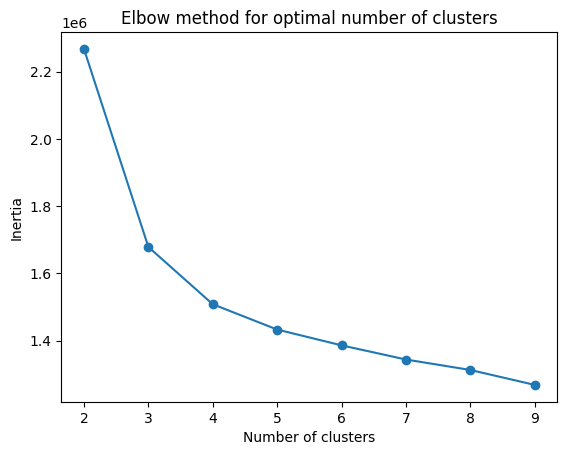

🏃 View run elbow_chart at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/c26baf9f32924d2cb96f98d98fddefb3
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


In [22]:
with mlflow.start_run(run_name="elbow_chart"):

    inertias = []
    for k in range(2, 10):
        model = KMeans(n_clusters=k, random_state=42).fit(X_perf_only_df)
        inertia = model.inertia_
        inertias.append(inertia)
        mlflow.log_metric(f"inertia_k_{k}", inertia)

    plt.plot(range(2, 10), inertias, marker='o')
    plt.title('Elbow method for optimal number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        mlflow.log_artifact(tmp.name, artifact_path="figures")

    plt.show()
    plt.close()
    
mlflow.end_run()


In [23]:
# will take this value for number of clusters
number_of_clusters = 4

In [24]:
# kmeans clustering with performance only. Pick k=6 based on the elbow plot
with mlflow.start_run(run_name="performance_only"):
    # taking 6 from elbow plot
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
    X_perf_only_df['cluster_perf_only'] = kmeans.fit_predict(X_perf_only_df)
    df.loc[X_perf_only_df.index, 'cluster_perf_only'] = X_perf_only_df['cluster_perf_only']

    mlflow.log_param("n_clusters", number_of_clusters)
    mlflow.log_param("features", "stations_zscore")
    mlflow.log_metric("inertia", kmeans.inertia_)

mlflow.end_run()

🏃 View run performance_only at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/2711ce8b353743d19fe7c0dfc96712a9
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


/var/folders/f0/vk5jvtwj7x75k0xkxt9b3tx40000gn/T/ipykernel_52004/2612332553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_perf_only_df['cluster_perf_only'] = kmeans.fit_predict(X_perf_only_df)
/var/folders/f0/vk5jvtwj7x75k0xkxt9b3tx40000gn/T/ipykernel_52004/2612332553.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[X_perf_only_df.index, 'cluster_perf_only'] = X_perf_only_df['cluster_perf_only']


In [25]:
# analyze cluster profiles from z-score clustering (no personal context)
cluster_profiles_perf_only = X_perf_only_df.groupby('cluster_perf_only').mean()

In [26]:
cluster_profiles_perf_only

,run_1_zscore,1000m Ski_zscore,roxzone_1_zscore,run_2_zscore,50m Sled Push_zscore,roxzone_2_zscore,run_3_zscore,50m Sled Pull_zscore,roxzone_3_zscore,run_4_zscore,80m Burpee Broad Jump_zscore,roxzone_4_zscore,run_5_zscore,1000m Row_zscore,roxzone_5_zscore,run_6_zscore,200m Farmer Carry_zscore,roxzone_6_zscore,run_7_zscore,100m Sandbag Lunges_zscore,roxzone_7_zscore,run_8_zscore,100 Wall Balls_zscore
cluster_perf_only,,,,,,,,,,,,,,,,,,,,,,,
0,0.343096,0.343654,0.232057,0.361066,0.302542,0.304373,0.351429,0.369658,0.322624,0.354225,0.348031,0.265346,0.341750,0.356781,0.327046,0.349106,0.357156,0.347020,0.341962,0.315129,0.290476,0.296208,0.292082
1,-2.703767,-3.545248,-1.722484,-2.954812,-2.406252,-1.779475,-2.905123,-2.436241,-1.821764,-2.924998,-2.164719,-1.316754,-2.835454,-3.518605,-1.803928,-2.895063,-2.645421,-1.922204,-2.870626,-2.337466,-1.617520,-2.422084,-2.109076
2,0.871888,0.661795,0.829537,1.128353,0.961610,1.225136,1.213530,1.185937,1.224524,1.259999,1.393979,0.998671,1.322992,0.785496,1.142525,1.291339,1.046598,1.103484,1.302424,1.341110,1.251395,1.491315,1.202704
3,-0.139433,0.032873,-0.171082,-0.185620,-0.169512,-0.327372,-0.206259,-0.280992,-0.336999,-0.217842,-0.354224,-0.300595,-0.235936,-0.014083,-0.322201,-0.225722,-0.204807,-0.312698,-0.225860,-0.287855,-0.344985,-0.298300,-0.264512


In [27]:
X_perf_only_df.shape

(167743, 24)

Save the cluster profiles

In [28]:
filename = 'hyrox_cluster_profiles_perf_only.csv'
file_path = os.path.join(data_processed_folder, filename)
cluster_profiles_perf_only.to_csv(file_path, index=True)

In [29]:
with mlflow.start_run(run_name="hyrox_cluster_profiles_perf_only"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_cluster_profiles_perf_only at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/231a04ecce4f4d00b1920e3e43daba0c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


**How to understand this?**

Each row is a cluster (group of similar athlets).
Each column represents the normalized average of a station or personal variable.

**List Clusters**

In [30]:
# for each cluster, sort the stations from best to worst
cluster_rankings = {}

for cluster_id, row in cluster_profiles_perf_only.iterrows():
    sorted_stations = row.sort_values(ascending=False)
    cluster_rankings[cluster_id] = sorted_stations

for cluster_id, ranking in cluster_rankings.items():
    print(f"\n✳️ CLUSTERS {cluster_id} RANKING:")
    print('='*41)
    print(ranking.to_string())


✳️ CLUSTERS 0 RANKING:
50m Sled Pull_zscore            0.369658
run_2_zscore                    0.361066
200m Farmer Carry_zscore        0.357156
1000m Row_zscore                0.356781
run_4_zscore                    0.354225
run_3_zscore                    0.351429
run_6_zscore                    0.349106
80m Burpee Broad Jump_zscore    0.348031
roxzone_6_zscore                0.347020
1000m Ski_zscore                0.343654
run_1_zscore                    0.343096
run_7_zscore                    0.341962
run_5_zscore                    0.341750
roxzone_5_zscore                0.327046
roxzone_3_zscore                0.322624
100m Sandbag Lunges_zscore      0.315129
roxzone_2_zscore                0.304373
50m Sled Push_zscore            0.302542
run_8_zscore                    0.296208
100 Wall Balls_zscore           0.292082
roxzone_7_zscore                0.290476
roxzone_4_zscore                0.265346
roxzone_1_zscore                0.232057

✳️ CLUSTERS 1 RANKING:
roxzone_4

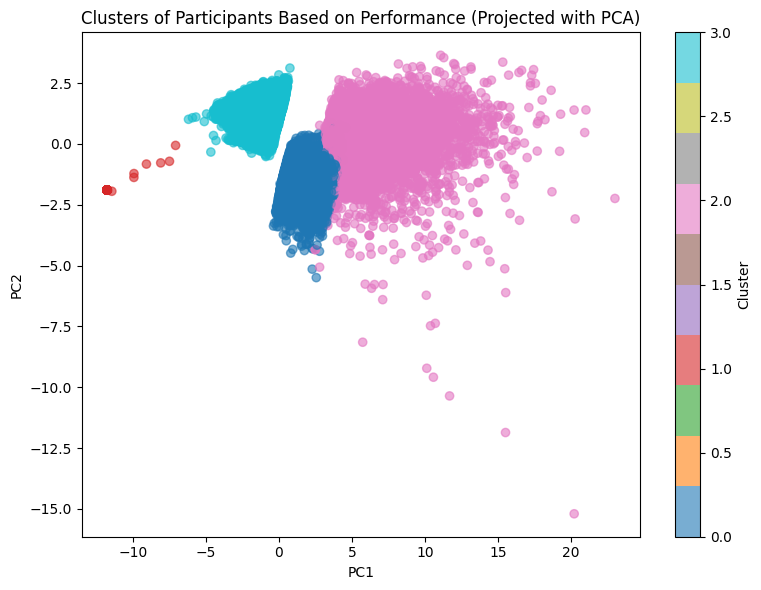

In [31]:
plot_pca_clusters(X_perf_only_df, X_perf_only_df['cluster_perf_only'], title="Clusters of Participants Based on Performance (Projected with PCA)")

**Note:**
This 2D plot visualize the clusters of participants based on their performance metrics only.

Each dot represents one participant.  Similar ones are grouped into the same cluster (indicated by color).


### 4.2 Performance + Personal Context Clustering

In [32]:
stations_zscore_context_cols = df.columns[59:85].tolist()
print(f"Stations Z-score Context columns: {stations_zscore_context_cols}")

Stations Z-score Context columns: ['gender_zscore_context', 'age_min_zscore_context', 'age_max_zscore_context', 'run_1_zscore_context', '1000m Ski_zscore_context', 'roxzone_1_zscore_context', 'run_2_zscore_context', '50m Sled Push_zscore_context', 'roxzone_2_zscore_context', 'run_3_zscore_context', '50m Sled Pull_zscore_context', 'roxzone_3_zscore_context', 'run_4_zscore_context', '80m Burpee Broad Jump_zscore_context', 'roxzone_4_zscore_context', 'run_5_zscore_context', '1000m Row_zscore_context', 'roxzone_5_zscore_context', 'run_6_zscore_context', '200m Farmer Carry_zscore_context', 'roxzone_6_zscore_context', 'run_7_zscore_context', '100m Sandbag Lunges_zscore_context', 'roxzone_7_zscore_context', 'run_8_zscore_context', '100 Wall Balls_zscore_context']


In [34]:
# remove rows with NaN values in 'age_min' and 'age_max' here to keep the saved file with NaN values
X_perf_context_df = df.dropna(subset=['age_min', 'age_max'])

In [35]:
X_perf_context_df = X_perf_context_df[stations_zscore_context_cols]

In [36]:
X_perf_context_df.shape

(167638, 26)

**Elbow Chart**

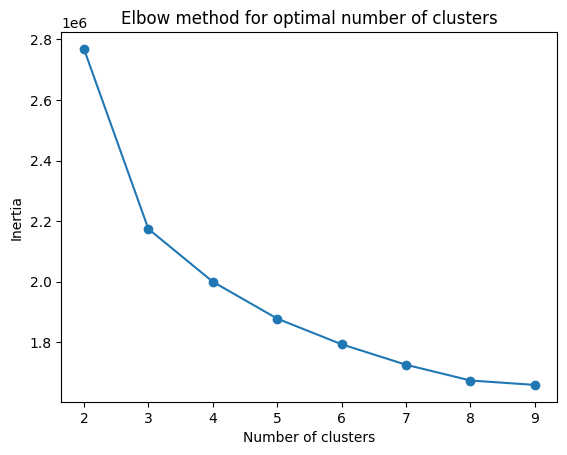

🏃 View run elbow_chart_perf_context at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/5e1bcd642fc74c94a3ab6e9301b72d23
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


In [37]:
with mlflow.start_run(run_name="elbow_chart_perf_context"):

    inertias = []
    for k in range(2, 10):
        model = KMeans(n_clusters=k, random_state=42).fit(X_perf_context_df)
        inertia = model.inertia_
        inertias.append(inertia)
        mlflow.log_metric(f"inertia_k_{k}", inertia)

    plt.plot(range(2, 10), inertias, marker='o')
    plt.title('Elbow method for optimal number of clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        plt.savefig(tmp.name)
        mlflow.log_artifact(tmp.name, artifact_path="figures")

    plt.show()
    plt.close()
    
mlflow.end_run()


>**Note:**
>
> Removing rows with null age values didn't significantly change the clustering results.

In [38]:
# kmeans clustering with performance and context. Pick k=6 based on the elbow plot
with mlflow.start_run(run_name="performance_with_context"):

    kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
    X_perf_context_df['cluster_perf_context'] = kmeans.fit_predict(X_perf_context_df)
    df.loc[X_perf_context_df.index, 'cluster_perf_context'] = X_perf_context_df['cluster_perf_context']
    df['cluster_perf_context'] = df['cluster_perf_context'].fillna(-1).astype(int)


    mlflow.log_param("n_clusters", number_of_clusters)
    mlflow.log_param("features", "stations_zscore_cols + age_min + age_max + gender")
    mlflow.log_metric("inertia", kmeans.inertia_)

mlflow.end_run()

🏃 View run performance_with_context at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/636a4955b9b34bf4a6141c51415d34ec
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


In [40]:
# analyze cluster profiles from z-score clustering with personal context
cluster_perf_context = X_perf_context_df.groupby('cluster_perf_context')[stations_zscore_context_cols].mean()

In [41]:
cluster_perf_context

,gender_zscore_context,age_min_zscore_context,age_max_zscore_context,run_1_zscore_context,1000m Ski_zscore_context,roxzone_1_zscore_context,run_2_zscore_context,50m Sled Push_zscore_context,roxzone_2_zscore_context,run_3_zscore_context,50m Sled Pull_zscore_context,roxzone_3_zscore_context,run_4_zscore_context,80m Burpee Broad Jump_zscore_context,roxzone_4_zscore_context,run_5_zscore_context,1000m Row_zscore_context,roxzone_5_zscore_context,run_6_zscore_context,200m Farmer Carry_zscore_context,roxzone_6_zscore_context,run_7_zscore_context,100m Sandbag Lunges_zscore_context,roxzone_7_zscore_context,run_8_zscore_context,100 Wall Balls_zscore_context
cluster_perf_context,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.201045,-0.198697,-0.205402,-0.153354,0.014561,-0.177637,-0.197193,-0.170338,-0.325866,-0.212484,-0.294414,-0.337305,-0.226064,-0.369538,-0.296074,-0.242376,-0.029027,-0.320559,-0.235008,-0.206701,-0.307988,-0.235708,-0.294337,-0.339107,-0.303093,-0.258703
1,0.010893,-0.089325,-0.083161,-2.703765,-3.545247,-1.722484,-2.954811,-2.406252,-1.779475,-2.905123,-2.436241,-1.821764,-2.924998,-2.164719,-1.316754,-2.835454,-3.518605,-1.803928,-2.895063,-2.645421,-1.922204,-2.870626,-2.337466,-1.617520,-2.422084,-2.109075
2,0.154636,0.212318,0.223117,0.860107,0.652821,0.815692,1.104364,0.949186,1.202781,1.185580,1.163944,1.206267,1.231745,1.368604,0.988519,1.293610,0.774717,1.129826,1.262297,1.030691,1.092087,1.273332,1.315811,1.236411,1.457619,1.183662
3,0.172350,0.167923,0.171004,0.337778,0.351235,0.220960,0.350954,0.280933,0.274013,0.334939,0.356768,0.292458,0.338856,0.333379,0.233358,0.323389,0.357451,0.294985,0.334583,0.334406,0.311312,0.328009,0.294500,0.252653,0.273752,0.258999


In [42]:
# save cluster profiles with context
filename = 'hyrox_cluster_profiles_perf_context.csv'
file_path = os.path.join(data_processed_folder, filename)
cluster_perf_context.to_csv(file_path, index=True)

In [43]:
with mlflow.start_run(run_name="hyrox_cluster_profiles_perf_context"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_cluster_profiles_perf_context at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/9d269f5321354f889c8b49806f6e6b2f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593


**How to understand this?**

Each row is a cluster (group of similar athlets).
Each column represents the normalized average of a station or personal variable.

**List Clusters by Performance & Context**

In [44]:
# for each cluster, sort the stations from best to worst
cluster_rankings_context = {}

for cluster_id, row in cluster_perf_context.iterrows():
    sorted_stations = row.sort_values(ascending=False)
    cluster_rankings_context[cluster_id] = sorted_stations

for cluster_id, ranking in cluster_rankings_context.items():
    print(f"\n✳️ CLUSTERS {cluster_id} RANKING:")
    print('='*41)
    print(ranking.to_string())


✳️ CLUSTERS 0 RANKING:
1000m Ski_zscore_context                0.014561
1000m Row_zscore_context               -0.029027
run_1_zscore_context                   -0.153354
50m Sled Push_zscore_context           -0.170338
roxzone_1_zscore_context               -0.177637
run_2_zscore_context                   -0.197193
age_min_zscore_context                 -0.198697
gender_zscore_context                  -0.201045
age_max_zscore_context                 -0.205402
200m Farmer Carry_zscore_context       -0.206701
run_3_zscore_context                   -0.212484
run_4_zscore_context                   -0.226064
run_6_zscore_context                   -0.235008
run_7_zscore_context                   -0.235708
run_5_zscore_context                   -0.242376
100 Wall Balls_zscore_context          -0.258703
100m Sandbag Lunges_zscore_context     -0.294337
50m Sled Pull_zscore_context           -0.294414
roxzone_4_zscore_context               -0.296074
run_8_zscore_context                   -0.303

In [ ]:
plot_pca_clusters(X_perf_context_df, X_perf_context_df['cluster_perf_context'], title="Clusters of Participants Based on Performance + Context (Projected with PCA)")

## 5. Save Clustered DataFrame

In [45]:
df.shape

(167743, 87)

In [46]:
df.head(1)

,id,event_name,gender,age_min,age_max,total_time,work_time,roxzone_time,run_time,run_1,1000m Ski,roxzone_1,run_2,50m Sled Push,roxzone_2,run_3,50m Sled Pull,roxzone_3,run_4,80m Burpee Broad Jump,roxzone_4,run_5,1000m Row,roxzone_5,run_6,200m Farmer Carry,roxzone_6,run_7,100m Sandbag Lunges,roxzone_7,run_8,100 Wall Balls,run_1_zscore,1000m Ski_zscore,roxzone_1_zscore,run_2_zscore,50m Sled Push_zscore,roxzone_2_zscore,run_3_zscore,50m Sled Pull_zscore,roxzone_3_zscore,run_4_zscore,80m Burpee Broad Jump_zscore,roxzone_4_zscore,run_5_zscore,1000m Row_zscore,roxzone_5_zscore,run_6_zscore,200m Farmer Carry_zscore,roxzone_6_zscore,run_7_zscore,100m Sandbag Lunges_zscore,roxzone_7_zscore,run_8_zscore,100 Wall Balls_zscore,total_time_zscore_agg,work_time_zscore_agg,roxzone_time_zscore_agg,run_time_zscore_agg,gender_zscore_context,age_min_zscore_context,age_max_zscore_context,run_1_zscore_context,1000m Ski_zscore_context,roxzone_1_zscore_context,run_2_zscore_context,50m Sled Push_zscore_context,roxzone_2_zscore_context,run_3_zscore_context,50m Sled Pull_zscore_context,roxzone_3_zscore_context,run_4_zscore_context,80m Burpee Broad Jump_zscore_context,roxzone_4_zscore_context,run_5_zscore_context,1000m Row_zscore_context,roxzone_5_zscore_context,run_6_zscore_context,200m Farmer Carry_zscore_context,roxzone_6_zscore_context,run_7_zscore_context,100m Sandbag Lunges_zscore_context,roxzone_7_zscore_context,run_8_zscore_context,100 Wall Balls_zscore_context,cluster_perf_only,cluster_perf_context
0,"111008_Diensthuber, Josef_GER",S6 2023 München,0,40.0,44.0,59.116667,25.516667,3.433333,30.166667,3.2,4.1,0.033333,3.6,2.116667,0.45,3.933333,3.333333,0.583333,3.85,3.3,0.65,3.8,4.216667,0.466667,3.833333,1.25,0.666667,3.783333,3.083333,0.583333,4.166667,4.116667,-0.827311,-0.261423,-1.639149,-0.807922,-0.591249,-0.916085,-0.766447,-0.853959,-0.710505,-0.819403,-0.913274,-0.456604,-0.892316,-0.406443,-0.921841,-0.839821,-1.106132,-0.884859,-0.85588,-0.914092,-0.926925,-0.771137,-0.703892,-0.95599,-0.868624,-1.15821,-0.884705,-0.696469,0.677415,0.682967,-0.827311,-0.261423,-1.639149,-0.807922,-0.591249,-0.916085,-0.766447,-0.853959,-0.710505,-0.819403,-0.913274,-0.456604,-0.892316,-0.406443,-0.921841,-0.839821,-1.106132,-0.884859,-0.85588,-0.914092,-0.926925,-0.771137,-0.703892,3,0


Save DataFrame with `cluster_perf_only` and `cluster_perf_context`

In [47]:
filename = 'hyrox_clean_cluster_dataset.csv'
file_path = os.path.join(data_processed_folder, filename)
df.to_csv(file_path, index=False)

In [48]:
with mlflow.start_run(run_name="hyrox_clean_cluster_dataset"):
    mlflow.log_artifact(file_path)
mlflow.end_run()

🏃 View run hyrox_clean_cluster_dataset at: http://127.0.0.1:8080/#/experiments/809278682180774593/runs/147ea03b6fa84c829bdcc7c323d19995
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/809278682180774593
